# A Deep Dive into CNN's 'Parts Unknown' TV Series with NLP in Python

>Anthony Bourdain: Parts Unknown is an American travel and food show on CNN which premiered on April 14, 2013. In the show, Anthony Bourdain travels the world uncovering lesser-known places and exploring their cultures and cuisine. * - https://en.wikipedia.org/wiki/Anthony_Bourdain:_Parts_Unknown*

This project will be split into two broad sections:
1. Scraping of the Episode Transcripts from the CNN website. As there is no readily available dataset, this file can be saved and used for future projects.
2. The NLP pipeline activities that will ultimately apply **Topic Modelling** and **Text Summarisation** to the dataset. 

## Contents
1. Scrape Episode Transcripts
2. Clean the Script Text
3. Visualise Cleaned Text and K-means output
4. Transcript Summaries
5. Topic Modelling

In [5]:
#Load Packages
import requests
import pandas as pd
from bs4 import BeautifulSoup
import json
import re
from urllib.request import Request, urlopen

## 1. Scrape Data

In [ ]:
headers = {'User-Agent': 'Mozilla/5.0 (X11; Linux x86_64) ' 
                      'AppleWebKit/537.11 (KHTML, like Gecko) '
                      'Chrome/23.0.1271.64 Safari/537.11',
        'Accept': 'text/html,application/xhtml+xml,application/xml;q=0.9,*/*;q=0.8',
        'Accept-Charset': 'ISO-8859-1,utf-8;q=0.7,*;q=0.3',
        'Accept-Encoding': 'none',
        'Accept-Language': 'en-US,en;q=0.8',
        'Connection': 'keep-alive'}

In [ ]:
base_url = 'https://transcripts.cnn.com'

In [ ]:
req = Request('https://transcripts.cnn.com/show/abpu', headers=headers)
html_page = urlopen(req)

In [ ]:
soup = BeautifulSoup(html_page, "lxml")

In [ ]:
links = []
for link in soup.find_all('a', href=True):
    links.append(link.get('href'))

In [ ]:
links = [i for i in links if i and i.startswith('/show/')]

In [ ]:
links

In [ ]:
len(links)

In [ ]:
ShowLinks = []
#For each link...
for i in range(0,len(links)):
    
    #...Find the page the link is going to...
    temp = links[i]
    
    #...Add the link to the website domain...
    temp = base_url + temp
    
    #...Add the finished link to our ShowLinks list...
    ShowLinks.append(temp)

In [ ]:
L = len(ShowLinks)

In [ ]:
data=[]

for i in range(0,L):
    url = ShowLinks[i]
    driver = requests.get(url,headers=headers) 
    soup2 = BeautifulSoup(driver.content, 'html.parser')
    
    episode = soup2.find_all('p',attrs={'class':'cnnTransSubHead'})
    transcript = soup2.find_all('p',attrs={'class':'cnnBodyText'})
    
    for e in episode:
        data.append(e.text)
        
    for t in transcript:
        data.append(t.text)

In [ ]:
data

In [ ]:
EpisodeScripts = pd.DataFrame()

In [ ]:
#Create DF of scraped data
EpisodeScripts = pd.DataFrame()

EpisodeScripts['Episode']=data[0::4]
EpisodeScripts['Date']=data[1::4]
EpisodeScripts['Script Text']=data[3::4]

In [ ]:
EpisodeScripts

In [ ]:
#Save DF to CSV file
EpisodeScripts.to_csv('Parts Unknown Scripts.csv', encoding='utf-8', index=False, header=True)

## 2. Cleaning the Script Text

In [6]:
#If starting from here...read data
EpisodeScripts = pd.read_csv('Parts Unknown Scripts.csv')

In [8]:
#import packages
import numpy as np
import neattext as nt
import neattext.functions as nfs
import texthero as hero

In [10]:
df = EpisodeScripts
df = df.rename(columns={"Script Text": "script"})

In [11]:
# Start with a noise scan to understand the level on noise we need to remove
df['script'].apply(lambda x : nt.TextFrame(x).noise_scan())

0     {'text_noise': 13.201080182800165, 'text_lengt...
1     {'text_noise': 13.040826904899838, 'text_lengt...
2     {'text_noise': 12.642194675390941, 'text_lengt...
3     {'text_noise': 11.83126808636937, 'text_length...
4     {'text_noise': 13.813309107426756, 'text_lengt...
                            ...                        
95    {'text_noise': 12.643929228944986, 'text_lengt...
96    {'text_noise': 12.746793721241392, 'text_lengt...
97    {'text_noise': 12.784576148248672, 'text_lengt...
98    {'text_noise': 12.458330807927753, 'text_lengt...
99    {'text_noise': 12.534709861160556, 'text_lengt...
Name: script, Length: 100, dtype: object

In [12]:
#Before we clean the script text, we can remove some unwanted custom strings from the 'Date' column of our dataframe.
custom_wordlist1 = ['Aired','ET']

df['Date'] = hero.remove_stopwords(df['Date'], custom_wordlist1)
df['Date'] = pd.to_datetime(df['Date'])
#We can also clean the Episode name column, removed the aired data after the '.'
df['Episode'] = df['Episode'].str.split('.',1).str[0]

In [13]:
df['Date'] = pd.to_datetime(df['Date'])

In [14]:
Season = [1,2,3,4,5,6,7,8,9,10,11,12]
FirstAired = ['April 14 2013','September 15 2013','April 13 2014','September 28 2014','April 26 2015', 'September 27 2015', 'April 24 2016', 'September 24 2016', 'April 23 2017', 'October 1 2017', 'April 29 2018','September 23 2018']
dl = ['September 15 2013','April 13 2014','September 28 2014','April 26 2015', 'September 27 2015', 'April 24 2016', 'September 24 2016', 'April 23 2017', 'October 1 2017', 'April 29 2018','September 23 2018', 'October 6 2021']
d = {'season': Season, 'firstaired': FirstAired, 'deadline' : dl}
Seasons = pd.DataFrame(data=d)

In [15]:
Seasons['firstaired'] = pd.to_datetime(Seasons['firstaired'])
Seasons['deadline'] = pd.to_datetime(Seasons['deadline'])

In [16]:
# Assign a 'Season' to each of the scraped epsiodes

conditions = [
    (df['Date'] <= '2013-09-15'),
    (df['Date'] > '2013-09-15') & (df['Date'] <= '2014-04-13'),
    (df['Date'] > '2014-04-13') & (df['Date'] <= '2014-09-28'),
    (df['Date'] > '2014-09-28') & (df['Date'] <= '2015-04-26'),
    (df['Date'] > '2015-04-26') & (df['Date'] <= '2015-09-27'),
    (df['Date'] > '2015-09-27') & (df['Date'] <= '2016-04-24'),
    (df['Date'] > '2016-04-24') & (df['Date'] <= '2016-09-24'),
    (df['Date'] > '2016-09-24') & (df['Date'] <= '2017-04-23'),
    (df['Date'] > '2017-04-23') & (df['Date'] <= '2017-10-01'),
    (df['Date'] > '2017-10-01') & (df['Date'] <= '2018-04-29'),
    (df['Date'] > '2018-04-29') & (df['Date'] <= '2018-09-23'),
    (df['Date'] > '2018-09-23')
    ]


# create a list of the values we want to assign for each condition
values = ['Season 1', 'Season 2', 'Season 3', 'Season 4','Season 5','Season 6','Season 7','Season 8','Season 9','Season 10','Season 11','Season 12']

# create a new column and use np.select to assign values to it using our lists as arguments
df['Season'] = np.select(conditions, values)


In [17]:
Seasons

season firstaired   deadline
0        1 2013-04-14 2013-09-15
1        2 2013-09-15 2014-04-13
2        3 2014-04-13 2014-09-28
3        4 2014-09-28 2015-04-26
4        5 2015-04-26 2015-09-27
5        6 2015-09-27 2016-04-24
6        7 2016-04-24 2016-09-24
7        8 2016-09-24 2017-04-23
8        9 2017-04-23 2017-10-01
9       10 2017-10-01 2018-04-29
10      11 2018-04-29 2018-09-23
11      12 2018-09-23 2021-10-06

In [18]:
df['cleanscript'] = df['script'].apply(nfs.remove_special_characters)
df['cleanscript'] = df['cleanscript'].apply(nfs.remove_stopwords)
df['cleanscript'] = df['cleanscript'].apply(nfs.remove_numbers)

### Normalise

In [19]:
df['cleanscript'] = df['cleanscript'].apply(nfs.remove_multiple_spaces)
df['cleanscript'] = df['cleanscript'].str.lower()
df['cleanscript'] = df['cleanscript'].apply(nfs.remove_puncts)

# REMOVE CUSTOM WORDS
custom_wordlist = ['commercial','break', 'bourdain','cnn', 'host','anthony','parts','unknown','unidentified','male','like']
df['cleanscript'] = hero.remove_stopwords(df['cleanscript'], custom_wordlist)

<AxesSubplot:>

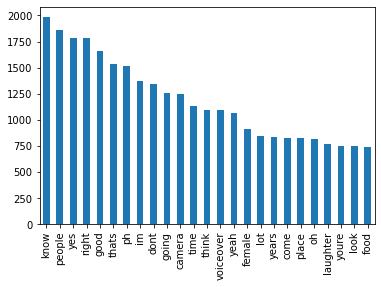

In [20]:
hero.visualization.top_words(df['cleanscript']).head(25).plot.bar()

In [21]:
df.head()

Episode                Date  \
0        Cologne, Germany 2016-06-05 21:00:00   
1  Parts Unknown: Senegal 2016-05-29 21:00:00   
2        Tbilisi, Georgia 2016-05-22 21:00:00   
3  Parts Unknown: Montana 2016-05-15 21:00:00   
4       The Greek Islands 2016-05-08 21:00:00   

                                              script    Season  \
0  (COMMERCIAL BREAK) [21:00:16] UNIDENTIFIED MAL...  Season 7   
1  [21:00:17] ANTHONY BOURDAIN, CNN HOST, "PARTS ...  Season 7   
2  [21:00:21] (SINGING IN GEORGIAN)  ANTHONY BOUR...  Season 7   
3  [21:00:19] ANTHONY BOURDAIN, CNN HOST:  Some p...  Season 7   
4  [21:00:00] ANTHONY BOURDAIN, CNN  HOST: People...  Season 7   

                                         cleanscript  
0      translator ground rules kolsch itll come c...  
1         places surprise youve traveling nearly ...  
2   singing georgian       georgia shalalaing pla...  
3       people live great spaces sky goes forever...  
4       people come stopping naxos island hopping...

### Tokenize

In [22]:
from nltk.tokenize import word_tokenize

In [23]:
df['tokenized_script'] = df.apply(lambda row: word_tokenize(row['cleanscript']), axis=1)

In [24]:
df['length'] = df.apply(lambda row: len(row['tokenized_script']), axis=1)

In [25]:
df.head()

Episode                Date  \
0        Cologne, Germany 2016-06-05 21:00:00   
1  Parts Unknown: Senegal 2016-05-29 21:00:00   
2        Tbilisi, Georgia 2016-05-22 21:00:00   
3  Parts Unknown: Montana 2016-05-15 21:00:00   
4       The Greek Islands 2016-05-08 21:00:00   

                                              script    Season  \
0  (COMMERCIAL BREAK) [21:00:16] UNIDENTIFIED MAL...  Season 7   
1  [21:00:17] ANTHONY BOURDAIN, CNN HOST, "PARTS ...  Season 7   
2  [21:00:21] (SINGING IN GEORGIAN)  ANTHONY BOUR...  Season 7   
3  [21:00:19] ANTHONY BOURDAIN, CNN HOST:  Some p...  Season 7   
4  [21:00:00] ANTHONY BOURDAIN, CNN  HOST: People...  Season 7   

                                         cleanscript  \
0      translator ground rules kolsch itll come c...   
1         places surprise youve traveling nearly ...   
2   singing georgian       georgia shalalaing pla...   
3       people live great spaces sky goes forever...   
4       people come stopping naxos island hopping...   

                                    tokenized_script  length  
0  [translator, ground, rules, kolsch, itll, come...    1442  
1  [places, surprise, youve, traveling, nearly, n...    2373  
2  [singing, georgian, georgia, shalalaing, playi...    2488  
3  [people, live, great, spaces, sky, goes, forev...    1898  
4  [people, come, stopping, naxos, island, hoppin...    1642

### Apply Kmeans

In [26]:
df['tfidf'] = df['cleanscript'].pipe(hero.tfidf)

In [27]:
df['PCA'] = df['tfidf'].pipe(hero.pca)

In [28]:
df['kmeanslabel'] = df['tfidf'].pipe(hero.kmeans,n_clusters = 5).astype(str)

C:\Users\A621096\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:786: FutureWarning: 'precompute_distances' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25). It has no effect
  warnings.warn("'precompute_distances' was deprecated in version "
C:\Users\A621096\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:792: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"


## 3. Visualisation

In [ ]:
import matplotlib.pyplot as plt

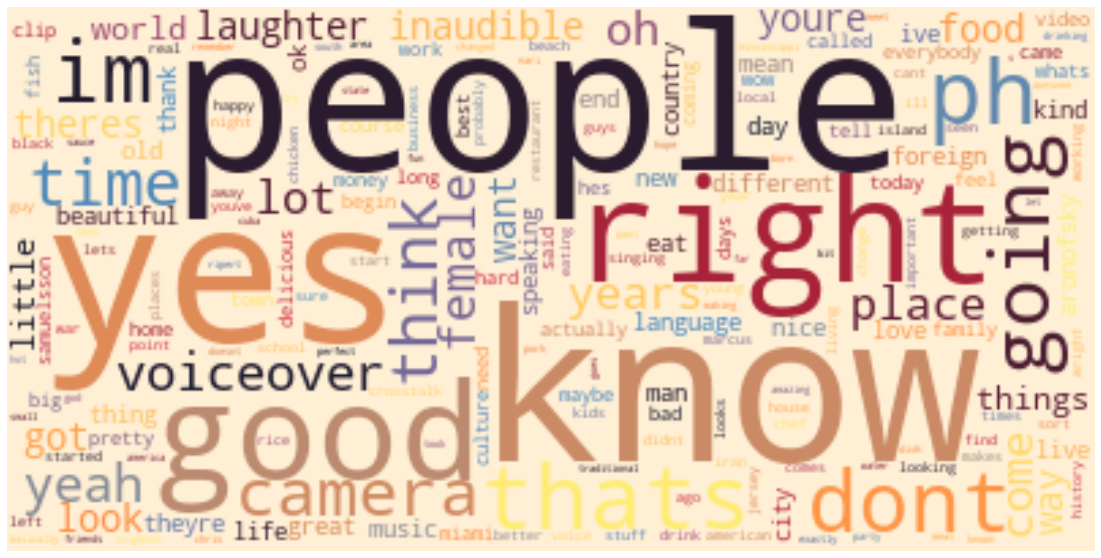

In [25]:
hero.visualization.wordcloud(df['cleanscript'],max_words = 200)

In [26]:
hero.scatterplot(df,'PCA',title = 'PCA for Parts Unknown Scripts', color = 'kmeanslabel')

### Lemmatization

In [29]:
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
set(stopwords.words('english'))

{'a',
 'about',
 'above',
 'after',
 'again',
 'against',
 'ain',
 'all',
 'am',
 'an',
 'and',
 'any',
 'are',
 'aren',
 "aren't",
 'as',
 'at',
 'be',
 'because',
 'been',
 'before',
 'being',
 'below',
 'between',
 'both',
 'but',
 'by',
 'can',
 'couldn',
 "couldn't",
 'd',
 'did',
 'didn',
 "didn't",
 'do',
 'does',
 'doesn',
 "doesn't",
 'doing',
 'don',
 "don't",
 'down',
 'during',
 'each',
 'few',
 'for',
 'from',
 'further',
 'had',
 'hadn',
 "hadn't",
 'has',
 'hasn',
 "hasn't",
 'have',
 'haven',
 "haven't",
 'having',
 'he',
 'her',
 'here',
 'hers',
 'herself',
 'him',
 'himself',
 'his',
 'how',
 'i',
 'if',
 'in',
 'into',
 'is',
 'isn',
 "isn't",
 'it',
 "it's",
 'its',
 'itself',
 'just',
 'll',
 'm',
 'ma',
 'me',
 'mightn',
 "mightn't",
 'more',
 'most',
 'mustn',
 "mustn't",
 'my',
 'myself',
 'needn',
 "needn't",
 'no',
 'nor',
 'not',
 'now',
 'o',
 'of',
 'off',
 'on',
 'once',
 'only',
 'or',
 'other',
 'our',
 'ours',
 'ourselves',
 'out',
 'over',
 'own',
 'r

In [30]:
import nltk
nltk.download('wordnet')
from nltk.corpus import wordnet


[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\A621096\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [31]:
lmtzr = WordNetLemmatizer()
df['lemmatized'] = df['tokenized_script'].apply(
                    lambda lst:[lmtzr.lemmatize(word) for word in lst])

### Parts of Speech Tagging

In [56]:
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\A621096\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping taggers\averaged_perceptron_tagger.zip.


True

In [68]:
df['POSTags'] = nltk.pos_tag_sents(df['lemmatized'].tolist())

## 4. Script Summaries

In [5]:
pip install genism

Note: you may need to restart the kernel to use updated packages.


ERROR: Could not find a version that satisfies the requirement genism
ERROR: No matching distribution found for genism


In [47]:
from gensim.summarization import summarize

ImportError: cannot import name 'has_pattern' from 'gensim.utils' (C:\Users\A621096\Anaconda3\lib\site-packages\gensim\utils.py)

In [45]:
df['summary'] = df.apply(lambda row: summarize(row['script'], ratio =0.15), axis=1)

NameError: name 'summarize' is not defined

In [81]:
df['summary'][1]

'(SHA-LA-LA-ING PLAYING) BOURDAIN:  At first you see what you see in so many places in Africa -- the noisy streets, busy markets, the controlled, consensual chaos of daily commerce.\nBOURDAIN:  How did you come to know and like and love this country?\nOFEIBEA QUIST-ARCTON, NPR AFRICA CORRESPONDENT:  I think it was just listening and watching and thinking, "Gosh, this is quite different to all the other countries I know."  For a start, the languages.\nQUIST-ARCTON:  (SPEAKS WOLOF) Sometimes you think people were quarrelling.\nBOURDAIN:  Ofeibea Quist-Arcton is the NPR Africa correspondent.\nI think the Senegalese are extraordinary, they\'re open, they welcome you, and, for me, that about makes a good place to live.\nBOURDAIN:  I fear I come with this assumption that Senegal will be yet  another failed state or yet another state that, that has gone through, uh, a really terrible post-colonial period that never really --that, that transitioned badly.\nQUIST-ARCTON:  You\'ll know that Sene

## 5. Topic Modelling w/ Genism

In [16]:
pip install --upgrade gensim

Note: you may need to restart the kernel to use updated packages.


In [32]:
import gensim.corpora as corpora
import gensim.utils
from gensim.utils import simple_preprocess
from gensim.utils import simple_preprocess

In [33]:
# Plotting tools
import pyLDAvis
import pyLDAvis.gensim_models
import matplotlib.pyplot as plt
%matplotlib inline



In [34]:
import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

C:\Users\A621096\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [35]:
df.head()

Episode                Date  \
0        Cologne, Germany 2016-06-05 21:00:00   
1  Parts Unknown: Senegal 2016-05-29 21:00:00   
2        Tbilisi, Georgia 2016-05-22 21:00:00   
3  Parts Unknown: Montana 2016-05-15 21:00:00   
4       The Greek Islands 2016-05-08 21:00:00   

                                              script    Season  \
0  (COMMERCIAL BREAK) [21:00:16] UNIDENTIFIED MAL...  Season 7   
1  [21:00:17] ANTHONY BOURDAIN, CNN HOST, "PARTS ...  Season 7   
2  [21:00:21] (SINGING IN GEORGIAN)  ANTHONY BOUR...  Season 7   
3  [21:00:19] ANTHONY BOURDAIN, CNN HOST:  Some p...  Season 7   
4  [21:00:00] ANTHONY BOURDAIN, CNN  HOST: People...  Season 7   

                                         cleanscript  \
0      translator ground rules kolsch itll come c...   
1         places surprise youve traveling nearly ...   
2   singing georgian       georgia shalalaing pla...   
3       people live great spaces sky goes forever...   
4       people come stopping naxos island hopping...   

                                    tokenized_script  length  \
0  [translator, ground, rules, kolsch, itll, come...    1442   
1  [places, surprise, youve, traveling, nearly, n...    2373   
2  [singing, georgian, georgia, shalalaing, playi...    2488   
3  [people, live, great, spaces, sky, goes, forev...    1898   
4  [people, come, stopping, naxos, island, hoppin...    1642   

                                               tfidf  \
0  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
1  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
2  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
3  [0.0, 0.0, 0.014808979407123408, 0.0, 0.0, 0.0...   
4  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   

                                              PCA kmeanslabel  \
0   [-0.015642985235699933, -0.05847261121910746]           0   
1  [-0.012264290540674795, -0.054469105284920584]           0   
2    [-0.0228721706681489, -0.054302163137522834]           0   
3    [-0.03190772748992192, -0.05944429921114413]           0   
4    [-0.00817812804613078, -0.04767168999402473]           0   

                                          lemmatized  
0  [translator, ground, rule, kolsch, itll, come,...  
1  [place, surprise, youve, traveling, nearly, no...  
2  [singing, georgian, georgia, shalalaing, playi...  
3  [people, live, great, space, sky, go, forever,...  
4  [people, come, stopping, naxos, island, hoppin...

In [38]:
bigram = gensim.models.Phrases(df['lemmatized'], min_count=5, threshold=100) # higher threshold fewer phrases.

In [39]:
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

NameError: name 'data_words' is not defined

In [40]:
data_lemmatized = df['lemmatized']

In [41]:
#create dictionary and corpus
#dictionary
id2word = corpora.Dictionary(data_lemmatized)
texts = data_lemmatized

In [42]:
# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]


In [43]:
# Human-friendly format of corpus (term-frequency)
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

[[('able', 1),
  ('absolute', 1),
  ('absolutely', 1),
  ('absorb', 1),
  ('absorption', 1),
  ('accepted', 1),
  ('accompaniment', 1),
  ('accustomed', 1),
  ('admired', 1),
  ('adult', 1),
  ('affair', 1),
  ('afford', 1),
  ('affordable', 1),
  ('afraid', 1),
  ('african', 1),
  ('ago', 1),
  ('aint', 1),
  ('airport', 1),
  ('al', 5),
  ('alcohol', 1),
  ('alcoholic', 1),
  ('ale', 1),
  ('amazing', 1),
  ('american', 2),
  ('amount', 1),
  ('anarchistic', 1),
  ('anke', 9),
  ('appealed', 1),
  ('applesauce', 1),
  ('arab', 1),
  ('argument', 2),
  ('arrive', 2),
  ('arrived', 1),
  ('art', 1),
  ('ashamed', 1),
  ('asking', 1),
  ('assaulting', 1),
  ('attire', 1),
  ('attired', 1),
  ('attitude', 3),
  ('avantgarde', 1),
  ('away', 4),
  ('awesome', 1),
  ('back', 1),
  ('bad', 3),
  ('band', 1),
  ('bard', 1),
  ('basted', 1),
  ('batshit', 1),
  ('beach', 1),
  ('beard', 1),
  ('beat', 1),
  ('beautiful', 2),
  ('beer', 16),
  ('beetroot', 1),
  ('beginning', 2),
  ('bei', 1),

In [44]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=5, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=10,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [45]:
print(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0, '0.008*"jersey" + 0.007*"know" + 0.007*"good" + 0.007*"time" + 0.007*"people" + 0.006*"yeah" + 0.006*"chris" + 0.005*"hawaiian" + 0.005*"going" + 0.005*"zsigmond"'), (1, '0.007*"camera" + 0.007*"voiceover" + 0.006*"clip" + 0.006*"glasgow" + 0.006*"samuelsson" + 0.006*"video" + 0.005*"time" + 0.005*"miller" + 0.005*"laughter" + 0.005*"end"'), (2, '0.011*"yes" + 0.010*"know" + 0.008*"people" + 0.008*"thats" + 0.008*"good" + 0.008*"right" + 0.007*"im" + 0.006*"going" + 0.006*"thing" + 0.006*"year"'), (3, '0.023*"ph" + 0.013*"aronofsky" + 0.011*"right" + 0.009*"people" + 0.008*"yes" + 0.008*"dont" + 0.008*"thats" + 0.008*"know" + 0.006*"good" + 0.006*"place"'), (4, '0.010*"good" + 0.010*"camera" + 0.009*"female" + 0.009*"yeah" + 0.008*"right" + 0.008*"foreign" + 0.008*"know" + 0.008*"iran" + 0.008*"language" + 0.007*"time"')]


In [68]:
# Visualize the topics
pyLDAvis.enable_notebook()
TopicsVis = pyLDAvis.gensim_models.prepare(lda_model, corpus, id2word)
TopicsVis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2     -0.047485 -0.004926       1        1  48.300319
3     -0.101971 -0.012237       2        1  16.968872
4     -0.114712 -0.032430       3        1  13.178110
0      0.167760 -0.139911       4        1  12.275711
1      0.096407  0.189505       5        1   9.276988, topic_info=           Term         Freq        Total Category  logprob  loglift
477          ph  1399.000000  1399.000000  Default  30.0000  30.0000
7523  aronofsky   487.000000   487.000000  Default  29.0000  29.0000
1001     female   813.000000   813.000000  Default  28.0000  28.0000
3737     camera  1127.000000  1127.000000  Default  27.0000  27.0000
1883       iran   231.000000   231.000000  Default  26.0000  26.0000
...         ...          ...          ...      ...      ...      ...
179        dont    74.383265  1236.075293   Topic5  -5.6109  -0.4328
267       going    67.172475  1165.674246   Topic5  -5.7128  -0.4762
269        good    68.589558  1592.354385   Topic5  -5.6919  -0.7672
119        city    61.138741   668.467967   Topic5  -5.8069  -0.0142
641      theyre    58.492566   516.995425   Topic5  -5.8512   0.1985

[343 rows x 6 columns], token_table=       Topic      Freq         Term
term                               
4394       5  0.963039     abusrour
12690      1  0.991680        akram
8489       1  0.985573    alejandro
8328       2  0.988529  andrianjaka
7523       2  0.999315    aronofsky
...      ...       ...          ...
731        4  0.079679        youre
731        5  0.073988        youre
11569      1  0.994546      zamboni
11710      3  0.968171     zanzibar
7755       4  0.993072     zsigmond

[497 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 4, 5, 1, 2])

The above charts show noticable overlap between 3 of the identified topics. The size of the circles indicate their dominance accross the documents whereas their position on the plot indiciate the level of uniqueness between the topics. Topics 5 and 4 can therefore be considered to be significantly different in nature to topics 1, 2 and 3 which experience the overlap. Topic number 1, whilst similar to 2 and 3, is a more dominant topic accross the lifecycle of the show.

In [100]:
lda_model.get_document_topics(corpus[1])

[(0, 0.014807336),
 (1, 0.035793368),
 (2, 0.84418625),
 (3, 0.06483499),
 (4, 0.04037809)]

In [46]:
#Add the most likely topic number to the episode df
def get_max(doc):
        idx,l = zip(*doc)
        return idx[np.argmax(l)]

df['topic'] = [get_max(doc) for doc in lda_model.get_document_topics(corpus)]

In [47]:
df.head(25)

Episode                Date  \
0                          Cologne, Germany 2016-06-05 21:00:00   
1                    Parts Unknown: Senegal 2016-05-29 21:00:00   
2                          Tbilisi, Georgia 2016-05-22 21:00:00   
3                    Parts Unknown: Montana 2016-05-15 21:00:00   
4                         The Greek Islands 2016-05-08 21:00:00   
5                   Parts Unknown - Chicago 2016-05-01 21:00:00   
6                     Parts Unknown: Manila 2016-04-24 21:00:00   
7        Parts Unknown: Prime Cuts Season 6 2016-04-24 20:00:00   
8                                 Jerusalem 2015-12-23 20:00:00   
9   Anthony Bourdain, Parts Unknown: Sicily 2015-12-22 21:00:00   
10                                     Cuba 2015-12-21 19:00:00   
11                                     Iran 2015-12-17 21:00:00   
12                                   Beirut 2015-12-10 21:00:00   
13                               Charleston 2015-11-15 21:00:00   
14                                   Turkey 2015-11-12 21:00:00   
15                                 Istanbul 2015-11-08 21:00:00   
16                                   Borneo 2015-11-08 20:00:00   
17                                 Ethiopia 2015-11-06 22:00:00   
18                                 Malaysia 2015-11-05 21:00:00   
19                                   Borneo 2015-11-01 21:00:00   
20                                 Ethiopia 2015-11-01 20:00:00   
21                                 Ethiopia 2015-10-25 21:00:00   
22                                  Okinawa 2015-10-23 22:00:00   
23                              South Korea 2015-10-23 21:00:00   
24                                  Okinawa 2015-10-15 21:00:00   

                                               script    Season  \
0   (COMMERCIAL BREAK) [21:00:16] UNIDENTIFIED MAL...  Season 7   
1   [21:00:17] ANTHONY BOURDAIN, CNN HOST, "PARTS ...  Season 7   
2   [21:00:21] (SINGING IN GEORGIAN)  ANTHONY BOUR...  Season 7   
3   [21:00:19] ANTHONY BOURDAIN, CNN HOST:  Some p...  Season 7   
4   [21:00:00] ANTHONY BOURDAIN, CNN  HOST: People...  Season 7   
5   (COMMERCIAL BREAK) [21:00:18] ANTHONY BOURDAIN...  Season 7   
6   (MUSIC PLAYING) [21:00:48] UNIDENTIFIED FEMALE...  Season 7   
7   [20:00:00] PAMELA BROWN, CNN ANCHOR:  I'm Pame...  Season 7   
8   ANTHONY BOURDAIN, HOST:  Where does falafel co...  Season 6   
9   ANTHONY BOURDAIN, HOST:  We go up this beautif...  Season 6   
10       (BEGIN VIDEOTAPE)       JOHN F. KENNEDY, ...  Season 6   
11  ANTHONY BOURDAIN, CNN HOST:  I am so confused....  Season 6   
12  ANTHONY BOURDAIN, CNN HOST:  There's no place ...  Season 6   
13  (COMMERCIAL BREAK) [21:00:25] ANTHONY BOURDAIN...  Season 6   
14  [21:00:00]  ANTHONY BOURDAIN, PARTS UNKNOWN HO...  Season 6   
15  ANTHONY BOURDAIN, CNN HOST (voice-over):  Mode...  Season 6   
16  (COMMERCIAL BREAK) [20:00:26] ANTHONY BOURDAIN...  Season 6   
17  ANTHONY BOURDAIN, PARTS UNKNOWN SHOW HOST:  Wh...  Season 6   
18  [21:00:00] ANTHONY BOURDAIN, CNN HOST:  When I...  Season 6   
19  (COMMERCIAL BREAK) [21:00:26] ANTHONY BOURDAIN...  Season 6   
20       (BEGIN VIDEO CLIP)      [20:18:00] ANTHON...  Season 6   
21       (BEGIN VIDEO CLIP)      [21:18:00] ANTHON...  Season 6   
22  [21:00:00] ANTHONY BOURDAIN, PARTS UNKNOWN HOS...  Season 6   
23  [21:00:00] ANTHONY BOURDAIN, CNN HOST: All I'm...  Season 6   
24  [21:00:00] ANTHONY BOURDAIN, PARTS UNKNOWN HOS...  Season 6   

                                          cleanscript  \
0       translator ground rules kolsch itll come c...   
1          places surprise youve traveling nearly ...   
2    singing georgian       georgia shalalaing pla...   
3        people live great spaces sky goes forever...   
4        people come stopping naxos island hopping...   
5        anchor somebody asks youre answer im chic...   
6   music playing  female huh week  female oh god ...   
7    pamela brown  anchor im pamela brown great we...   
8      falafel come makes best hummus

In [107]:
# Plot
# import libraries
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

In [108]:
# set plot style: grey grid in the background:
sns.set(style="darkgrid")
# set the figure size
plt.figure(figsize=(14, 14))

In [48]:
plotdf = df[['Episode','Season','topic']].copy()

In [49]:
plotdf.head()

Episode    Season  topic
0        Cologne, Germany  Season 7      2
1  Parts Unknown: Senegal  Season 7      2
2        Tbilisi, Georgia  Season 7      2
3  Parts Unknown: Montana  Season 7      2
4       The Greek Islands  Season 7      2

In [54]:
plotdf = plotdf.pivot_table(
        values='Episode', index='topic', columns='Season',
        fill_value=0, aggfunc='count')

In [55]:
plotdf

Season  Season 4  Season 5  Season 6  Season 7
topic                                         
0              0        11         5         0
1              1         5         5         0
2             17        13         9         8
3              1        11         3         0
4              2         7         2         0

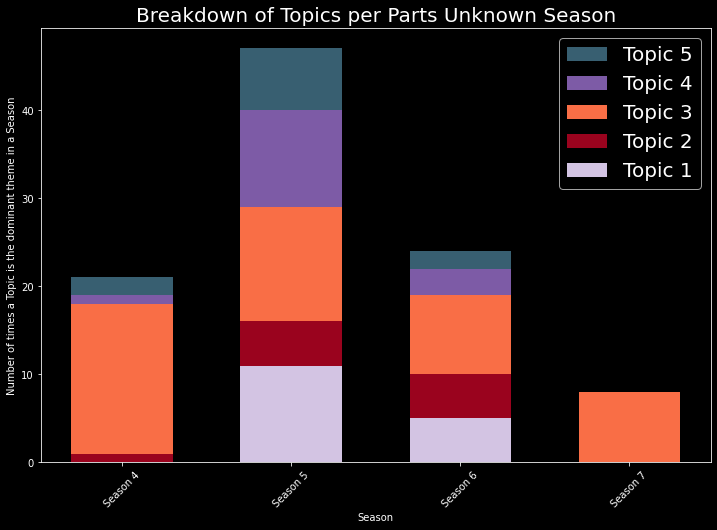

In [61]:
Season = plotdf.columns
Topic1 = plotdf.iloc[0]
Topic2 = plotdf.iloc[1]
Topic3 = plotdf.iloc[2]
Topic4 = plotdf.iloc[3]
Topic5 = plotdf.iloc[4]

ind = [x for x, _ in enumerate(Season)]

plt.style.use('dark_background')
plt.figure(figsize=(12,8))

plt.bar(ind, Topic5, width=0.6, label='Topic 5', color='#385F71', bottom=Topic1+Topic2+Topic3+Topic4)
plt.bar(ind, Topic4, width=0.6, label='Topic 4', color='#7D5BA6', bottom=Topic1+Topic2+Topic3)
plt.bar(ind, Topic3, width=0.6, label='Topic 3', color='#F96E46', bottom=Topic1+Topic2)
plt.bar(ind, Topic2, width=0.6, label='Topic 2', color='#9A031E', bottom=Topic1)
plt.bar(ind, Topic1, width=0.6, label='Topic 1', color='#D3C4E3')

plt.xticks(ind, Season)
plt.ylabel("Number of times a Topic is the dominant theme in a Season")
plt.xlabel("Season")
plt.legend(loc="upper right", prop={'size':20})
plt.xticks(rotation='45')
plt.title("Breakdown of Topics per Parts Unknown Season", fontsize=20)

plt.show()

# Analysis: Wordcount and Frequency